<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12a_MatMulExplainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Multiplication explainer
A tool for explaining the output value from matrix multiplication, particularly for near-zero outputs.

In [314]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout ea80c40
!cd repo && git pull

import sys
sys.path.append('repo')

import matmul_explainer as me
from importlib import reload
reload(me)

HEAD is now at 8789437 describe_groups()
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.00 KiB | 342.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   8789437..0c703ef  main       -> origin/main
Updating 8789437..0c703ef
Fast-forward
 matmul_explainer.py | 176 ++++++++++++++++++++++++++++++++++++++++++++++--------------------------
 1 file changed, 114 insertions(+), 62 deletions(-)


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [315]:
import matmul_explainer_test
reload(me)
reload(matmul_explainer_test)
matmul_explainer_test.run_test_suite()

All matmul_explainer tests passed.


In [238]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math

## Classification
First we need to be able to classify the components that make up the matrix multiplication results.

We do that with a number of functions:

```
def classify_terms():
  return ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']

def matmul_classify(x1, x2, confidence: float=0.95, threshold1: float = None, threshold2: float = None):
 ...
 return counts, sums
```


In [107]:
# Standard ordered terms
print(f"Terms: {me.classify_terms()}")

Terms: ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']


In [108]:
# Check that the summarisation API works under a number of usages:
reload(me)
a = np.arange(0.0, 1.0, 0.1)
a = np.tile(a, (10,1))
counts, sums = me.matmul_classify(a, a, confidence=0.75)

print(f"Summary when passed counts and sums separately:\n  {me.summarise(counts, sums)}")
print(f"Summary when passed counts and sums directly from classification:\n  {me.summarise(me.matmul_classify(a, a, confidence=0.75))}")


Summary when passed counts and sums separately:
  PP: 640 = Σ 193.6, ZP: 160 = Σ 4.4, PZ: 160 = Σ 4.4, ZZ: 40 = Σ 0.1
Summary when passed counts and sums directly from classification:
  PP: 640 = Σ 193.6, ZP: 160 = Σ 4.4, PZ: 160 = Σ 4.4, ZZ: 40 = Σ 0.1


In [117]:
# Show how the values within tensors get classified
def show_classification_results(x, confidence):
  p, z, n, t = me.classification_mask(x, confidence=confidence)
  print(f"classification results for {x} @ {confidence}:")
  print(f"  threshold: {t}")
  print(f"  p: {p}")
  print(f"  z: {z}")
  print(f"  n: {n}")

a = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
show_classification_results(a, confidence=0.75)

a = np.array([-0.5, 0, -0.5])
show_classification_results(a, confidence=0.75)

a = np.array([-0.5, 0.25, 0, 0.25, -0.5])
show_classification_results(a, confidence=0.95)

classification results for [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] @ 0.75:
  threshold: 0.25
  p: [False False False  True  True  True  True  True  True  True]
  z: [ True  True  True False False False False False False False]
  n: [False False False False False False False False False False]
classification results for [-0.5  0.  -0.5] @ 0.75:
  threshold: 0.25
  p: [False False False]
  z: [False  True False]
  n: [ True False  True]
classification results for [-0.5   0.25  0.    0.25 -0.5 ] @ 0.95:
  threshold: 0.125
  p: [False  True False  True False]
  z: [False False  True False False]
  n: [ True False False False  True]


In [118]:
# Simple 2D matmul explanation
reload(me)
a = np.arange(0.0, 1.0, 0.1)
a = np.tile(a, (10,1))
print(f"a = b = {a}")

counts, sums = me.matmul_classify(a, a, confidence=0.75)

print()
print("Details...")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[:,:,i]) > 0:
    print(f"Counts({name}): {counts[:,:,i]}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[:,:,i]) > 0:
    print(f"Sums({name}): {sums[:,:,i]}")

print()
print("Summary...")
print(f"Classes: {me.classify_terms()}")
print(f"Counts by class: {np.sum(counts, axis=(0,1))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1))}")
print(f"Summary: {me.summarise(counts, sums)}")

print()
print("Validation...")
print(f"True matmul: {np.matmul(a, a)}")
print(f"Derived matmul: {np.sum(sums, axis=-1)}")


a = b = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]]

Details...
Counts(PP): [[0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]]
Counts(PZ): [[8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]]
Counts(ZP): [[0 0 2 2 2 2 2 2 2 2]
 [0 0 2 2 2 2 2 2 2 2]
 [0 0

In [119]:
# 2D convolution explanation
a = np.arange(0.0, 0.9, 0.1)
a = np.tile(a, (9,1)).astype(np.float32)
a = tf.reshape(a, shape=(1,9,9,1))
print(f"a = b: {a.shape} = {a[0,:,:,0]}")

k = np.array([
    [-1, 0, -1],
    [+1, +1, +1],
    [-1, 0, -1]
]).astype(np.float32)
k = tf.reshape(k, shape=(3,3,1,1))
print(f"k = {k.shape} = {k[:,:,0,0]}")

counts, sums = me.conv_classify(a, k, confidence=0.75)
print()
print("Results...")
print(f"Shapes: counts={counts.shape}, sums={sums.shape}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Counts({name}): {counts[0,:,:,0,i]}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Sums({name}): {sums[0,:,:,0,i]}")

print()
print("Summary...")
print(f"Classes: {me.classify_terms()}")
print(f"Counts by class: {np.sum(counts, axis=(0,1,2,3))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1,2,3))}")
print(f"Summary: {me.summarise(counts, sums)}")

print()
print("Validation...")
expected_conv = tf.nn.convolution(a, k)
derived_conv = tf.reduce_sum(sums, axis=-1)
print(f"True conv: {expected_conv.shape} = {expected_conv[0,:,:,0]}")
print(f"Derived conv: {derived_conv.shape} = {derived_conv[0,:,:,0]}")
print(f"Devired conv == true conv: {np.allclose(expected_conv, derived_conv)}")


a = b: (1, 9, 9, 1) = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]]
k = (3, 3, 1, 1) = [[-1.  0. -1.]
 [ 1.  1.  1.]
 [-1.  0. -1.]]

Results...
Shapes: counts=(1, 7, 7, 1, 9), sums=(1, 7, 7, 1, 9)
Counts(PP): [[1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]]
Counts(PZ): [[0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]]
Counts(PN): [[2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [

In [120]:
# 1D convolution explanation
reload(me)
a = np.arange(0.0, 0.9, 0.1).astype(np.float32)
a = tf.reshape(a, shape=(1,9,1))
print(f"a = b: {a.shape} = {a[0,:,0]}")

k = np.array([-1, 0, -1]).astype(np.float32)
k = tf.reshape(k, shape=(3,1,1))
print(f"k = {k.shape} = {k[:,0,0]}")

counts, sums, thresholds = me.conv_classify(a, k, confidence=0.90, return_thresholds=True)
print()
print("Results...")
print(f"Shapes: counts={counts.shape}, sums={sums.shape}, thresholds={thresholds}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Counts({name}): {counts[0,:,0,i]}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Sums({name}): {sums[0,:,0,i]}")

print()
print("Summary...")
print(f"Classes: {me.classify_terms()}")
print(f"Counts by class: {np.sum(counts, axis=(0,1,2))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1,2))}")
print(f"Summary: {me.summarise(counts, sums)}")

print()
print("Validation...")
expected_conv = tf.nn.convolution(a, k)
derived_conv = tf.reduce_sum(sums, axis=-1)
print(f"True conv: {expected_conv.shape} = {expected_conv[0,:,0]}")
print(f"Derived conv: {derived_conv.shape} = {derived_conv[0,:,0]}")
print(f"Devired conv == true conv: {np.allclose(expected_conv, derived_conv)}")

a = b: (1, 9, 1) = [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
k = (3, 1, 1) = [-1.  0. -1.]

Results...
Shapes: counts=(1, 7, 1, 9), sums=(1, 7, 1, 9), thresholds=[0.05, 0.5]
Counts(PZ): [1. 1. 1. 1. 1. 1. 1.]
Counts(PN): [1. 2. 2. 2. 2. 2. 2.]
Counts(ZN): [1. 0. 0. 0. 0. 0. 0.]
Sums(PZ): [0. 0. 0. 0. 0. 0. 0.]
Sums(PN): [-0.2       -0.4       -0.6       -0.8       -1.        -1.2
 -1.4000001]
Sums(ZN): [0. 0. 0. 0. 0. 0. 0.]

Summary...
Classes: ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']
Counts by class: [ 0.  7. 13.  0.  0.  1.  0.  0.  0.]
Sums by class: [ 0.   0.  -5.6  0.   0.   0.   0.   0.   0. ]
Summary: PN: 13.0 = Σ -5.600, PZ: 7.0 = Σ 0.000, ZN: 1.0 = Σ 0.000

Validation...
True conv: (1, 7, 1) = [-0.2       -0.4       -0.6       -0.8       -1.        -1.2
 -1.4000001]
Derived conv: (1, 7, 1) = [-0.2       -0.4       -0.6       -0.8       -1.        -1.2
 -1.4000001]
Devired conv == true conv: True


In [121]:
# Simple single tensor explanation
a = np.arange(0.0, 0.9, 0.1).astype(np.float32)
a = tf.reshape(a, shape=(1,9,1))

counts, sums, thresholds = me.tensor_classify(a, confidence=0.90, return_threshold=True)
print(f"Shapes: counts={counts.shape}, sums={sums.shape}, thresholds={thresholds}")
print(f"Classes: {me.classify_terms(counts)}")
print(f"Counts by class: {np.sum(counts, axis=(0,1,2))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1,2))}")
print(f"Summary: {me.summarise(counts, sums)}")



Shapes: counts=(1, 9, 1, 3), sums=(1, 9, 1, 3), thresholds=0.05000000074505806
Classes: ['P', 'Z', 'N']
Counts by class: [8. 1. 0.]
Sums by class: [3.6 0.  0. ]
Summary: P: 8.0 = Σ 3.600, Z: 1.0 = Σ 0.000


## Detailed Summary
Now for a more detailed summarisation that works with masking to identify the range of causes for problems with specific output tensor positions.

Counts: (100, 100, 9) in range 0 .. 32
Sums:   (100, 100, 9) in range -223.0 .. 228.0
Basic summary: PP: 164979 = Σ 1020838, NP: 159367 = Σ -993079, PN: 158899 = Σ -995126, NN: 153428 = Σ 971861, PZ: 82322 = Σ 0, ZP: 81454 = Σ 0, NZ: 80005 = Σ 0, ZN: 78673 = Σ 0, ZZ: 40873 = Σ 0


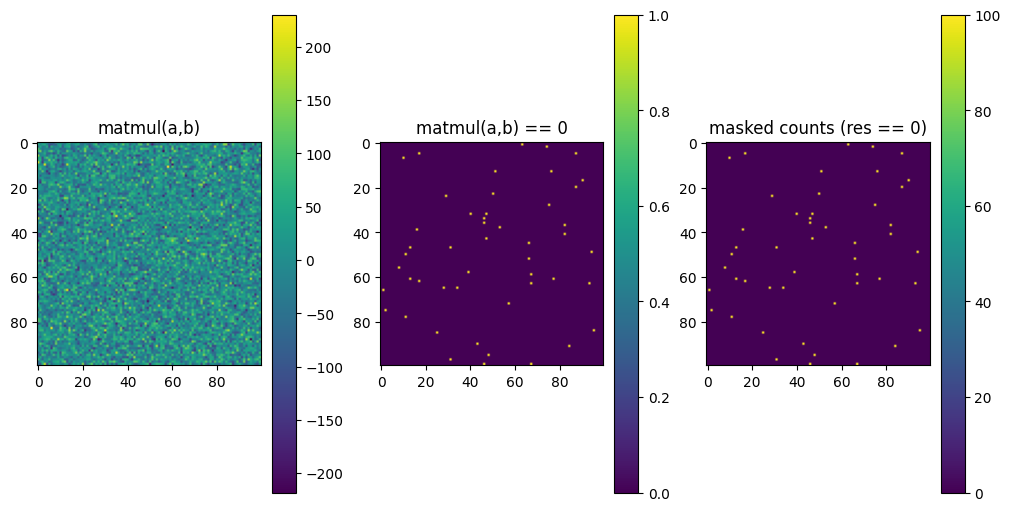

In [122]:
def get_test_data():
  np.random.seed(36)
  a = np.random.uniform(-5, +5, (100,100)).astype(int).astype(float)
  b = np.random.uniform(-5, +5, (100,100)).astype(int).astype(float)
  return a, b

a, b = get_test_data()
res = np.matmul(a, b)
counts, sums = me.matmul_classify(a,b)

print(f"Counts: {counts.shape} in range {np.min(counts)} .. {np.max(counts)}")
print(f"Sums:   {sums.shape} in range {np.min(sums)} .. {np.max(sums)}")
print(f"Basic summary: {me.summarise(me.matmul_classify(a,b))}")

plt.figure(figsize=(10,5), layout='constrained')

plt.subplot(1,3,1)
plt.title("matmul(a,b)")
plt.imshow(res)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("matmul(a,b) == 0")
plt.imshow(res == 0, vmin=0., vmax=1.)
plt.colorbar()

plt.subplot(1,3,3)
mask = res == 0
masked_counts = counts * mask[..., np.newaxis]
plt.title('masked counts (res == 0)')
plt.imshow(np.sum(masked_counts, axis=-1))
plt.colorbar()

plt.show()


sorted counts: (100, 100, 9)
sorted counts: (100, 100, 9)


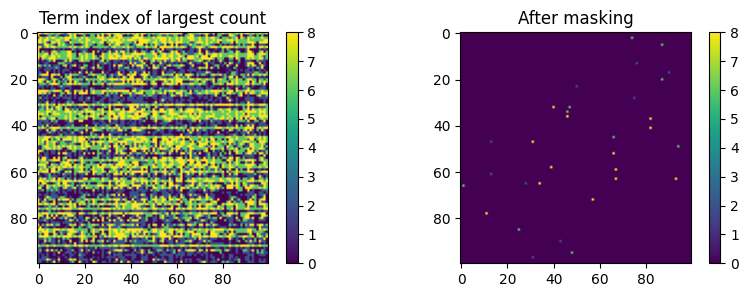

In [ ]:
# let's sort by count and pick the largest count
a, b = get_test_data()
res = np.matmul(a, b)
counts, sums = me.matmul_classify(a,b)

argsrt = np.argsort(counts, axis=-1)
print(f"sorted counts: {argsrt.shape}")

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('Term index of largest count')
plt.imshow(argsrt[:,:,-1])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('After masking')
argsrt = argsrt * mask[..., np.newaxis]
print(f"sorted counts: {argsrt.shape}")
plt.imshow(argsrt[:,:,-1])
plt.colorbar()

plt.show()

In [123]:
# Let's try listing out the detailed values for the first 10 near-zero values
a, b = get_test_data()
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)

for i, indices in enumerate(zip(*np.where(mask))):
  if i > 10:
    break
  print(f"index: {indices} - counts: {counts[indices]} - sums: {sums[indices]}")

index: (1, 63) - counts: [20  5 15  9  3 11 13 11 13] - sums: [ 121.    0. -124.    0.    0.    0.  -66.    0.   69.]
index: (2, 74) - counts: [18  6  9  5  7 12 21  9 13] - sums: [ 127.    0.  -80.    0.    0.    0. -117.    0.   70.]
index: (5, 17) - counts: [20  5 11 18  5  8 14  8 11] - sums: [ 99.   0. -57.   0.   0.   0. -90.   0.  48.]
index: (5, 87) - counts: [14 12 10 11  9 11 20  3 10] - sums: [  97.    0.  -70.    0.    0.    0. -121.    0.   94.]
index: (7, 10) - counts: [17 10 14 13  4  9 15  6 12] - sums: [  92.    0. -113.    0.    0.    0.  -74.    0.   95.]
index: (13, 51) - counts: [18 10 14  2  4 15 14 10 13] - sums: [ 126.    0.  -95.    0.    0.    0. -110.    0.   79.]
index: (13, 76) - counts: [18  6 18  7  3 11 16  6 15] - sums: [ 108.    0.  -95.    0.    0.    0. -105.    0.   92.]
index: (17, 90) - counts: [18 11 19  5  3  6 15 12 11] - sums: [ 126.    0. -133.    0.    0.    0.  -81.    0.   88.]
index: (20, 87) - counts: [16  9 11  9  5  8 20 10 12] - sums:

**Filtering:**
* Next we can apply filtering to the results to discard the least important 25% or so of the explanation. This helps in simplifying the explanation, but it will also help with grouping later on.

In [124]:
# Filtering classifications - simple example
counts = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [8, 7, 6, 5, 4, 3, 2, 1, 0],
])
sums = np.array([
    [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
    [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
    [8, 15, 21, 26, 30, 33, 35, 36, 0],
])
counts, sums, terms = me.filter_classifications(counts, sums, completeness=0.75)
print(f"counts: {counts}")
print(f"sums: {sums}")
print(f"terms: {terms}")

counts: [[8 7 6 5 4 0 0 0 0]
 [8 7 6 5 4 3 1 0 0]
 [8 7 6 5 4 3 2 1 0]]
sums: [[36 28 21 15 10  0  0  0  0]
 [10 15  6 21  3 28 36  0  0]
 [ 8 15 21 26 30 33 35 36  0]]
terms: [['NN' 'NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PN' 'PZ' 'PP']
 ['NN' 'NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PZ' 'PN' 'PP']
 ['PP' 'PZ' 'PN' 'ZP' 'ZZ' 'ZN' 'NP' 'NZ' 'NN']]


In [317]:
# Filtering classifications - our big example
def list_masked_classifications(mask, counts, sums, terms=None):
  for i, indices in enumerate(zip(*np.where(mask))):
    if i > 10:
      break
    if terms is None:
      print(f"  index: {indices} - counts: {counts[indices]} - sums: {sums[indices]}")
    else:
      print(f"  index: {indices} - counts: {counts[indices]} - sums: {sums[indices]} - terms: {terms[indices]}")

a, b = get_test_data()
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)
terms = me.classify_terms(counts, retain_shape=True)

# before
print(f"Before filtering:")
list_masked_classifications(mask, counts, sums)

# apply filtering
counts, sums, terms = me.filter_classifications(counts, sums)

# NOTE that the summary doesn't work anymore, because the terms have been all mixed up
print(f"After filtering:")
list_masked_classifications(mask, counts, sums, terms)

Before filtering:
  index: (1, 63) - counts: [20  5 15  9  3 11 13 11 13] - sums: [ 121.    0. -124.    0.    0.    0.  -66.    0.   69.]
  index: (2, 74) - counts: [18  6  9  5  7 12 21  9 13] - sums: [ 127.    0.  -80.    0.    0.    0. -117.    0.   70.]
  index: (5, 17) - counts: [20  5 11 18  5  8 14  8 11] - sums: [ 99.   0. -57.   0.   0.   0. -90.   0.  48.]
  index: (5, 87) - counts: [14 12 10 11  9 11 20  3 10] - sums: [  97.    0.  -70.    0.    0.    0. -121.    0.   94.]
  index: (7, 10) - counts: [17 10 14 13  4  9 15  6 12] - sums: [  92.    0. -113.    0.    0.    0.  -74.    0.   95.]
  index: (13, 51) - counts: [18 10 14  2  4 15 14 10 13] - sums: [ 126.    0.  -95.    0.    0.    0. -110.    0.   79.]
  index: (13, 76) - counts: [18  6 18  7  3 11 16  6 15] - sums: [ 108.    0.  -95.    0.    0.    0. -105.    0.   92.]
  index: (17, 90) - counts: [18 11 19  5  3  6 15 12 11] - sums: [ 126.    0. -133.    0.    0.    0.  -81.    0.   88.]
  index: (20, 87) - counts: 

**Extended summaries**

* extend summarise() to accept a `terms` component so that it re-arranges the counts and sums for consistent terms (note that it'll now have the usual 9 + a '--', and should ignore anything with the '--')
* extend summarise() to accept a `mask` component so that only shows results across those
* extend summarise() to accept a `show_percentages` to list counts as percentages instead of absolute values
* extend summarise() to accept a `show_means` to list the sums as means instead of absolute values, indicating the result via ".. x ..." instead of ".. = ..".
* additionally extends it in a number of other ways to support genarating summaries from groups


In [318]:
a, b = get_test_data()
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)

print(f"Default summary:")
print(f"  Absolute: {me.summarise(counts, sums)}")
print(f"  Relative: {me.summarise(counts, sums, show_percentages=True, show_means=True)}")
print(f"  Range:    {me.summarise(counts, sums, show_ranges=True)}")

print(f"Summary with masking:")
print(f"  Absolute: {me.summarise(counts, sums, mask=mask)}")
print(f"  Relative: {me.summarise(counts, sums, mask=mask, show_percentages=True, show_means=True)}")
print(f"  Range:    {me.summarise(counts, sums, mask=mask, show_ranges=True)}")

counts, sums, terms = me.filter_classifications(counts, sums, completeness=0.75)
print(f"Summary after filtering:")
print(f"  Absolute: {me.summarise(counts, sums, terms)}")
print(f"  Relative: {me.summarise(counts, sums, terms, show_percentages=True, show_means=True)}")
print(f"  Range:    {me.summarise(counts, sums, terms, show_ranges=True)}")

print(f"Summary after filtering and masking:")
print(f"  Absolute: {me.summarise(counts, sums, terms, mask=mask)}")
print(f"  Relative: {me.summarise(counts, sums, terms, mask=mask, show_percentages=True, show_means=True)}")
print(f"  Range:    {me.summarise(counts, sums, terms, mask=mask, show_ranges=True)}")


Default summary:
  Absolute: PP: 164979 = Σ 1020838, NP: 159367 = Σ -993079, PN: 158899 = Σ -995126, NN: 153428 = Σ 971861, PZ: 82322 = Σ 0, ZP: 81454 = Σ 0, NZ: 80005 = Σ 0, ZN: 78673 = Σ 0, ZZ: 40873 = Σ 0
  Relative: PP: 16.5% x 6.188, NP: 15.9% x -6.231, PN: 15.9% x -6.263, NN: 15.3% x 6.334, PZ: 8.2% x 0.000, ZP: 8.1% x 0.000, NZ: 8.0% x 0.000, ZN: 7.9% x 0.000, ZZ: 4.1% x 0.000
  Range:    PP: 5..30 x 25.0..228.0, NP: 5..32 x -17.0..-223.0, PN: 4..29 x -10.0..-210.0, NN: 3..31 x 18.0..219.0, PZ: 1..21 x 0.0..0.0, ZP: 0..19 x 0.0..0.0, NZ: 0..19 x 0.0..0.0, ZN: 0..18 x 0.0..0.0, ZZ: 0..12 x 0.0..0.0
Summary with masking:
  Absolute: PP: 831 = Σ 5007, NP: 788 = Σ -4999, PN: 773 = Σ -4800, NN: 736 = Σ 4792, PZ: 400 = Σ 0, NZ: 388 = Σ 0, ZN: 386 = Σ 0, ZP: 383 = Σ 0, ZZ: 215 = Σ 0
  Relative: PP: 17.0% x 6.025, NP: 16.1% x -6.344, PN: 15.8% x -6.210, NN: 15.0% x 6.511, PZ: 8.2% x 0.000, NZ: 7.9% x 0.000, ZN: 7.9% x 0.000, ZP: 7.8% x 0.000, ZZ: 4.4% x 0.000
  Range:    PP: 0..22 x 0.0

**Grouping**

Now we want to be able to group a collection of masked classifications and to show higher-level summary statistics across the groups.

For example, after masking perhaps we still have 100 entries, each with their own counts and sums across the terms. However, perhaps the largest majority of them follow a very similar pattern.

Through simple filtering we've already eliminated the bottom 25% of variation. Now let's group by having the same _order_ of terms.


In [319]:
a, b = get_test_data()
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)
counts, sums, terms = me.filter_classifications(counts, sums, completeness=0.5)

count_groups, sum_groups, term_groups = me.group_classifications(counts, sums, terms, mask=mask)
print(f"Number of groups: {len(counts)}")
for i in range(min(10, len(counts))):
  group_counts = count_groups[i]
  group_sums = sum_groups[i]
  group_terms = term_groups[i]
  print(f"  [{i}]: len={len(group_counts)}, counts={group_counts.shape} in range {np.min(group_counts)}..{np.max(group_counts)}, "
        f"sums={group_sums.shape} in range {np.min(group_sums)}..{np.max(group_sums)}, terms={group_terms}")
print(f"  ...")

Number of groups: 100
  [0]: len=3, counts=(3, 9) in range 0..20, sums=(3, 9) in range -124.0..121.0, terms=['PP', 'PN', 'NP', 'NN']
  [1]: len=3, counts=(3, 9) in range 0..22, sums=(3, 9) in range -132.0..115.0, terms=['PP', 'PN', 'NN']
  [2]: len=3, counts=(3, 9) in range 0..22, sums=(3, 9) in range -127.0..118.0, terms=['PN', 'PP', 'NN']
  [3]: len=3, counts=(3, 9) in range 0..20, sums=(3, 9) in range -113.0..125.0, terms=['NP', 'NN', 'PN']
  [4]: len=3, counts=(3, 9) in range 0..18, sums=(3, 9) in range -149.0..141.0, terms=['NN', 'NP', 'PN']
  [5]: len=2, counts=(2, 9) in range 0..19, sums=(2, 9) in range -126.0..135.0, terms=['PP', 'PN', 'NP']
  [6]: len=2, counts=(2, 9) in range 0..18, sums=(2, 9) in range -118.0..124.0, terms=['PP', 'PN', 'NN', 'NP']
  [7]: len=2, counts=(2, 9) in range 0..21, sums=(2, 9) in range -92.0..107.0, terms=['PP', 'ZP', 'NP']
  [8]: len=2, counts=(2, 9) in range 0..21, sums=(2, 9) in range -132.0..128.0, terms=['PP', 'NP', 'PN']
  [9]: len=2, counts=(

**Filtering Groups**

In preparation for displaying summaries of those groups, we'll also want to filter them.


In [321]:
a, b = get_test_data()
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)
counts, sums, terms = me.filter_classifications(counts, sums, completeness=0.75)

print(f"Without max_groups:")
count_groups, sum_groups, term_groups = me.group_classifications(counts, sums, terms, mask=mask)
print(f"  grouped: {len(count_groups)} groups")
count_groups, sum_groups, term_groups, coverage = me.filter_groups(count_groups, sum_groups, term_groups, completeness=0.75, return_coverage=True)
print(f"  filtered: {len(count_groups)} groups")
print(f"  {coverage=}")

print()
print(f"With max_groups=10:")
count_groups, sum_groups, term_groups = me.group_classifications(counts, sums, terms, mask=mask)
print(f"  grouped: {len(count_groups)} groups")
count_groups, sum_groups, term_groups, coverage = me.filter_groups(count_groups, sum_groups, term_groups, completeness=0.75, max_groups=10, return_coverage=True)
print(f"  filtered: {len(count_groups)} groups")
print(f"  {coverage=}")

Without max_groups:
  grouped: 45 groups
  filtered: 33 groups
  coverage=0.7551020408163265

With max_groups=10:
  grouped: 45 groups
  filtered: 10 groups
  coverage=0.2857142857142857


**Summary of Groups**

Finally, now we want to collect stats across those groups, and devise a way to format that in a human readable way.

In [331]:
a, b = get_test_data()
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)
counts, sums, terms = me.filter_classifications(counts, sums, completeness=0.5)
count_groups, sum_groups, term_groups = me.group_classifications(counts, sums, terms, mask=mask)
count_groups, sum_groups, term_groups = me.filter_groups(count_groups, sum_groups, term_groups)
desc = me.describe_groups(count_groups, sum_groups, term_groups, show_ranges=True)

total = np.sum(mask)
print(f"masked count: {total}")
for i, (size, summary) in enumerate(zip(desc['sizes'], desc['summaries'])):
  print(f"[group {i:2d}]: size = {size} ({size/total*100:.1f}% of masked positions) - {summary}")


masked count: 49
[group  0]: size = 3 (6.1% of masked positions) - ZZ: 18..20 x 84.0..121.0, ZP: 15..17 x -97.0..-124.0, ZN: 13..17 x -66.0..-124.0, PZ: 12..15 x 69.0..120.0
[group  1]: size = 3 (6.1% of masked positions) - ZZ: 19..22 x 95.0..102.0, ZP: 17..18 x -113.0..-132.0, ZN: 15..16 x 60.0..115.0
[group  2]: size = 3 (6.1% of masked positions) - ZP: 19..22 x -95.0..-127.0, ZZ: 18..21 x 84.0..118.0, ZN: 14..16 x 73.0..84.0
[group  3]: size = 3 (6.1% of masked positions) - ZP: 18..20 x -97.0..-113.0, ZN: 18..18 x 105.0..125.0, ZZ: 15..16 x -80.0..-92.0
[group  4]: size = 3 (6.1% of masked positions) - ZN: 18..18 x 98.0..141.0, ZP: 17..18 x -88.0..-149.0, ZZ: 16..16 x -89.0..-101.0
[group  5]: size = 2 (4.1% of masked positions) - ZZ: 18..19 x 117.0..135.0, ZP: 18..18 x -111.0..-126.0, ZN: 15..15 x -94.0..-99.0
[group  6]: size = 2 (4.1% of masked positions) - ZZ: 17..18 x 104.0..124.0, ZP: 16..17 x -118.0..-118.0, PZ: 15..15 x 76.0..107.0, ZN: 12..14 x -82.0..-93.0
[group  7]: size

## Appendix: other helper functions


In [102]:
def _format_decimal(value, significant_digits=4, scale=None, return_scale=False):
  """
  Variant of the standard number formatting that is optimised first for easier visual comparison
  across multiple numbers potentially ranging wildly across different scales,
  and for compactness second.
  This is achieved by targeting the number of displayed significant digits, regardless
  of scale, and by avoiding scientific notation except for the largest values.

  Can be used to construct a shared scale across multiple numbers, eg:
  > max_value = np.max(values)
  > _, scale = _format_decimal(max_value, return_scale=True)
  > formatted = [_format_decimal(value, scale=scale) for value in values]

  Args:
    value: the value to format
    significant_digits: number of non-zero digits wanted for display
    scale: use this scale instead of calculating from the given value.
  """
  if scale is None:
    scale = int(np.floor(np.log10(abs(value))))

  if scale < 0:
    p = significant_digits-scale+1  # more digits as the number gets smaller
    res = f"{value:.{p}f}"
  elif scale >= 0:
    p = max(0, significant_digits-scale-1)  # less digits as the number gets larger
    res = f"{value:.{p}f}"

  # todo: switch to scientific notation if length of standard display is 2x length of scientific notation

  if return_scale:
    return res, scale
  else:
    return res

lst = [0.0000000000002345678, 0.00002345678, 0.0002345678, 0.2340042342342342342342134, 5.875634, 58.75634, 587.5634, 5875.634, 100000.423442423, 987654.234234, 9876543.5234234, 9876543.56789012345443, 98765435678901.2345443]
b = 5
for a in lst:
  print(f"{_format_decimal(a)} - {a}")

print()
lst = [0.0000000000002345678, 0.00002345678, 0.0002345678, 0.2340042342342342342342134, 5.875634, 58.75634, 587.5634, 5875.634, 100000.423442423, 987654.234234, 9876543.5234234, 9876543.56789012345443, 98765435678901.2345443]
b = 5
for a in lst:
  print(f"{_format_decimal(a, scale=3)} - {a}")


0.000000000000234568 - 2.345678e-13
0.0000234568 - 2.345678e-05
0.000234568 - 0.0002345678
0.234004 - 0.23400423423423422
5.876 - 5.875634
58.76 - 58.75634
587.6 - 587.5634
5876 - 5875.634
100000 - 100000.423442423
987654 - 987654.234234
9876544 - 9876543.5234234
9876544 - 9876543.567890123
98765435678901 - 98765435678901.23

0 - 2.345678e-13
0 - 2.345678e-05
0 - 0.0002345678
0 - 0.23400423423423422
6 - 5.875634
59 - 58.75634
588 - 587.5634
5876 - 5875.634
100000 - 100000.423442423
987654 - 987654.234234
9876544 - 9876543.5234234
9876544 - 9876543.567890123
98765435678901 - 98765435678901.23
